# **Comparative Analysis of T5 and BART Models for Disfluent Question Rewriting: Training, Evaluation, and Overconfidence Assessment**

# Installing Necessary Libraries
## Installation of Required Libraries
This cell installs essential libraries such as transformers, datasets, torch, scikit-learn, and nltk. These libraries are crucial for building, training, and evaluating the NLP models.

In [ ]:
# Install necessary libraries
!pip install transformers datasets torch scikit-learn nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.8 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


Installing these libraries ensures that the environment is equipped with the necessary tools for the subsequent tasks, including model training, data handling, and evaluation.

# Importing Libraries and Mounting Google Drive
This cell imports all the necessary Python libraries required for NLP model development, such as torch, transformers, and nltk. Additionally, it mounts Google Drive to access and store data.

In [ ]:
import os
import torch
import torch.nn.functional as F
import json
import requests
import matplotlib.pyplot as plt
import numpy as np
from transformers import (BartTokenizer, BartForConditionalGeneration,
                          GPT2Tokenizer, GPT2LMHeadModel,
                          T5Tokenizer, T5ForConditionalGeneration,
                          Trainer, TrainingArguments)
from datasets import Dataset, load_metric
import nltk
nltk.download('wordnet')
from nltk.translate.gleu_score import sentence_gleu
from sklearn.calibration import calibration_curve

[nltk_data] Downloading package wordnet to /root/nltk_data...


Importing relevant libraries and mounting Google Drive is vital for setting up the environment. It allows for seamless data access and handling throughout the notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
!nvidia-smi

Wed Sep  4 14:51:16 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Downloading the Datasets
## Downloading the Disfl QA Datasets
This cell defines a function to download the datasets (train, dev) from the given URLs and stores them locally.

In [ ]:
# Download datasets
def download_file(url, filename):
    response = requests.get(url)
    response.raise_for_status()  # Check for HTTP errors
    with open(filename, 'wb') as f:
        f.write(response.content)

urls = {
    "train": "https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/train.json",
    "dev": "https://raw.githubusercontent.com/google-research-datasets/Disfl-QA/main/dev.json",
}

for name, url in urls.items():
    download_file(url, f"{name}.json")

print("Files downloaded successfully.")

Files downloaded successfully.


Downloading and saving the datasets locally ensures that they are readily available for data preprocessing, training, and evaluation tasks. The function also checks for any HTTP errors during the download process, ensuring reliability.

# Loading the Datasets
## Loading Disfl QA Data
This cell defines a function to load the JSON data and extracts relevant fields ("original" and "disfluent") from the datasets.

In [ ]:
# Load data
def load_disflqa_data(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return [{"original": v["original"], "disfluent": v["disfluent"]} for v in data.values()]

train_data = load_disflqa_data('train.json')
dev_data = load_disflqa_data('dev.json')

Loading and processing the datasets into the desired format is a crucial step, as it prepares the data for tokenization and model training. The extraction of "original" and "disfluent" fields focuses the dataset on the specific task at hand.

# Data Augmentation for Question Rewrite Model
This cell contains several functions for augmenting the Disfl QA dataset to enhance model training.
## Synonym Replacement:
Replaces certain words with their synonyms to improve the model's ability to handle varied vocabulary.
## Filler Word Insertion:
Inserts random filler words like "um," "uh," etc., to simulate natural disfluencies in speech.
## Random Deletion:
Randomly deletes words from a sentence to create more challenging examples.
Word Swapping: Swaps adjacent words to mimic minor typing errors.
## Noise Injection:
Adds random noise characters to the sentence to simulate noisy input.
## Combined Augmentation:
The final function applies all the above augmentations in sequence, offering a comprehensive transformation of the input data.

In [ ]:
# Data Augmentation for Question Rewrite Model

import random
from nltk.corpus import wordnet
import re

# Function to perform synonym replacement
def synonym_replacement(sentence):
    words = sentence.split()
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replacements = max(1, int(0.1 * len(random_word_list)))

    for random_word in random_word_list[:num_replacements]:
        synonyms = wordnet.synsets(random_word)
        if synonyms:
            synonym = synonyms[0].lemmas()[0].name()
            new_words = [synonym if word == random_word else word for word in new_words]

    return ' '.join(new_words)

# Function to insert random filler words
def insert_filler_words(sentence):
    filler_words = ['um', 'uh', 'you know', 'like']
    words = sentence.split()
    num_insertions = random.randint(1, max(1, int(0.2 * len(words))))
    for _ in range(num_insertions):
        insert_position = random.randint(0, len(words) - 1)
        filler = random.choice(filler_words)
        words.insert(insert_position, filler)
    return ' '.join(words)

# Function to randomly delete words from the sentence
def random_deletion(sentence, p=0.2):
    words = sentence.split()
    if len(words) == 1:  # Return the original sentence if it only has one word
        return sentence

    new_words = [word for word in words if random.uniform(0, 1) > p]
    if len(new_words) == 0:
        return words[random.randint(0, len(words)-1)]  # Return a single word if all were deleted
    return ' '.join(new_words)

# Function to swap adjacent words in the sentence
def word_swap(sentence):
    words = sentence.split()
    if len(words) < 2:
        return sentence

    idx = random.randint(0, len(words) - 2)
    words[idx], words[idx + 1] = words[idx + 1], words[idx]
    return ' '.join(words)

# Function to inject noise characters into the sentence
def noise_injection(sentence):
    noise_chars = ['@', '#', '$', '%', '^', '&', '*']
    words = list(sentence)
    num_noises = random.randint(1, max(1, int(0.1 * len(words))))
    for _ in range(num_noises):
        noise_position = random.randint(0, len(words) - 1)
        words.insert(noise_position, random.choice(noise_chars))
    return ''.join(words)

# Function to apply a combination of augmentations to a sentence
def augment_sentence(sentence):
    try:
        sentence = synonym_replacement(sentence)
    except:
        pass
    try:
        sentence = insert_filler_words(sentence)
    except:
        pass
    try:
        sentence = random_deletion(sentence)
    except:
        pass
    try:
        sentence = word_swap(sentence)
    except:
        pass
    try:
        sentence = noise_injection(sentence)
    except:
        pass
    return sentence

# Example of augmenting the dataset
original_sentence = "What is the capital of France?"
augmented_sentence = augment_sentence(original_sentence)

print("Original:", original_sentence)
print("Augmented:", augmented_sentence)

Original: What is the capital of France?
Augmented: the #is capital of France?


The augmentation functions can be applied to each sentence in your dataset to generate new, augmented examples. This helps the model generalize better by learning from a more diverse range of disfluent inputs.
The data is then converted into a format suitable for use with the datasets library.

In [ ]:
augmented_train_data = []

for example in train_data:
    augmented_disfluent = augment_sentence(example['disfluent'])

    # Append original and augmented examples to the dataset
    augmented_train_data.append(example)
    augmented_train_data.append({
        'original': example['original'],
        'disfluent': augmented_disfluent
    })

train_dataset = Dataset.from_list(augmented_train_data)
dev_dataset = Dataset.from_list(dev_data)

# Tokenization Function
## Tokenizing Disfl QA Data
This cell defines a function for tokenizing the input data. It converts the disfluent questions into the format required by the model and tokenizes both inputs and targets using a specified tokenizer.

In [ ]:
# Tokenization function
def tokenize_function(example, tokenizer):
    inputs = [f"fix question: {q}" for q in example["disfluent"]]
    targets = example["original"]
    model_inputs = tokenizer(inputs, max_length=128, truncation=True, padding="max_length")

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(targets, max_length=128, truncation=True, padding="max_length")

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

Tokenization is a critical preprocessing step in NLP tasks. By tokenizing the input data, the model can process and understand the text more effectively during training and evaluation.

# Creating a Trainer Function
## Trainer Configuration for Model Training
This cell defines a function to create a Trainer object for the models. It includes various training arguments, such as learning rate, batch size, number of epochs, and more. The function also tokenizes the datasets and returns a Trainer instance for each model.

In [ ]:
# Create Trainer
def create_trainer(model_name, model, tokenizer, train_dataset, eval_dataset):
    training_args = TrainingArguments(
        output_dir=f"./results/{model_name}",
        evaluation_strategy="epoch",  # Use "steps" if you prefer
        save_strategy="epoch",        # Make sure this matches the evaluation strategy
        learning_rate=25e-6,  # Adjusted learning rate
        lr_scheduler_type='cosine_with_restarts',  # Using a different LR scheduler
        per_device_train_batch_size=32,  # Increased batch size
        per_device_eval_batch_size=32,  # Increased batch size
        num_train_epochs=25,  # Increased number of epochs
        weight_decay=0.1,  # Adjusted weight decay
        gradient_accumulation_steps=8,  # Increase to accumulate more gradients
        fp16=True,  # Mixed precision training
        logging_dir=f'./logs/{model_name}',
        logging_steps=1,
        load_best_model_at_end=True,  # Early stopping
        save_total_limit=1,  # Limit model checkpoints to avoid clutter
        )

    train_tokenized = train_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)
    eval_tokenized = eval_dataset.map(lambda x: tokenize_function(x, tokenizer), batched=True)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_tokenized,
        eval_dataset=eval_tokenized,
        tokenizer=tokenizer
    )

    return trainer

The Trainer function is essential for encapsulating the model training process. By adjusting various hyperparameters, this function enables efficient model training and evaluation. Tokenizing the datasets within this function ensures that the data is properly formatted for training.

# Loading Models and Tokenizers
## Initializing Models and Tokenizers
This cell initializes different NLP models (T5, BART, GPT) along with their respective tokenizers. It checks and adjusts tokenizers if necessary (e.g., adding a padding token).

In [ ]:
# Load models and tokenizers
models_and_tokenizers = {
    "T5": (T5ForConditionalGeneration.from_pretrained('t5-small').to(device), T5Tokenizer.from_pretrained('t5-small')),
    "BART": (BartForConditionalGeneration.from_pretrained('facebook/bart-base').to(device), BartTokenizer.from_pretrained('facebook/bart-base')),
    "GPT": (GPT2LMHeadModel.from_pretrained('gpt2').to(device), GPT2Tokenizer.from_pretrained('gpt2'))
}

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Initializing models and tokenizers is a crucial step that prepares the models for training. Ensuring that tokenizers are compatible with the models prevents issues during the training process, such as mismatches in input length.

In [ ]:
for name, (model, tokenizer) in models_and_tokenizers.items():
    if tokenizer.pad_token is None:
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})
        model.resize_token_embeddings(len(tokenizer))
        model.config.pad_token_id = tokenizer.eos_token_id
    models_and_tokenizers[name] = (model, tokenizer)

# Creating Trainers for Models
## Creating Trainers for All Models
This cell creates Trainer objects for each of the models (T5, BART, GPT) using the previously defined create_trainer function.

In [ ]:
trainers = {}
for name, (model, tokenizer) in models_and_tokenizers.items():
    trainers[name] = create_trainer(name, model, tokenizer, train_dataset, dev_dataset)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14364 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14364 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Map:   0%|          | 0/14364 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:4016: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:482: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Creating Trainer instances for each model enables parallel training and evaluation of multiple models. This approach is efficient for comparing model performance on the same task.

# Training and Evaluating the Models
## Training and Evaluating Models
This cell trains each model (T5, BART, GPT) and evaluates their performance on the validation dataset. It saves both the models and tokenizers after training.

In [ ]:
# Train and evaluate models
for name, trainer in trainers.items():
    print(f"Training {name}...")
    trainer.train()
    print(f"Evaluating {name}...")
    eval_results = trainer.evaluate()
    print(f"{name} Evaluation Results: {eval_results}")

    # Save the model and tokenizer
    model_save_path = f"./saved_model/{name}"
    tokenizer_save_path = f"./saved_tokenizer/{name}"
    trainer.save_model(model_save_path)
    models_and_tokenizers[name][1].save_pretrained(tokenizer_save_path)

Training T5...


Epoch,Training Loss,Validation Loss
0,0.883200,0.251696
1,0.372100,0.209017
2,0.269700,0.105829
3,0.212200,0.052321
4,0.169100,0.044532
5,0.179100,0.041449
6,0.167100,0.038908
8,0.148600,0.035069
9,0.154600,0.033630
10,0.144500,0.032677


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


Evaluating T5...


T5 Evaluation Results: {'eval_loss': 0.029791001230478287, 'eval_runtime': 2.6223, 'eval_samples_per_second': 381.348, 'eval_steps_per_second': 12.203, 'epoch': 24.94432071269488}
Training BART...


Epoch,Training Loss,Validation Loss
0,3.374100,2.671944
1,0.759500,0.403633
2,0.146600,0.040193
3,0.111700,0.027737
4,0.079800,0.025251
5,0.086500,0.024598
6,0.079800,0.024242
8,0.064400,0.023900
9,0.065300,0.023788
10,0.056400,0.023583


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Epoch,Training Loss,Validation Loss
0,3.374100,2.671944
1,0.759500,0.403633
2,0.146600,0.040193
3,0.111700,0.027737
4,0.079800,0.025251
5,0.086500,0.024598
6,0.079800,0.024242
8,0.064400,0.023900
9,0.065300,0.023788
10,0.056400,0.023583


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file

Evaluating BART...


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}


BART Evaluation Results: {'eval_loss': 0.023438027128577232, 'eval_runtime': 3.9951, 'eval_samples_per_second': 250.306, 'eval_steps_per_second': 8.01, 'epoch': 24.94432071269488}
Training GPT...


Epoch,Training Loss,Validation Loss
0,0.723700,0.674715
1,0.672900,0.649404
2,0.684400,0.637245
3,0.659200,0.628844
4,0.659200,0.623858
5,0.667500,0.619270
6,0.644800,0.615201
8,0.640200,0.610770
9,0.642500,0.608996
10,0.606200,0.608072


There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Evaluating GPT...


GPT Evaluation Results: {'eval_loss': 0.6046818494796753, 'eval_runtime': 4.4684, 'eval_samples_per_second': 223.795, 'eval_steps_per_second': 7.161, 'epoch': 24.94432071269488}


Training and evaluation are the core steps in model development. This cell captures and prints the training loss, validation loss, and other metrics to monitor model performance. Saving the models and tokenizers ensures that the trained models can be reused or further fine-tuned if needed.

# Training Analysis
## T5 Model:
The T5 model demonstrated a steady reduction in both training and validation losses throughout the training process. The final training loss stabilized at approximately 0.0469, with the validation loss reaching a low of 0.0298. This trend indicates that the T5 model effectively learned the mapping from disfluent to fluent questions, achieving a good balance between underfitting and overfitting. The consistent performance across epochs suggests a well-optimized model with minimal signs of overfitting.
## BART Model:
The BART model showed faster convergence compared to T5, with a notable drop in both training and validation losses in the early epochs. The final validation loss for BART was around 0.0234, which is lower than that of T5. This suggests that BART might have a slight advantage in modeling the specific task. The rapid convergence and lower final loss imply that BART was more efficient in capturing the underlying patterns from the training data.
## GPT Model:
The GPT model exhibited slower convergence and higher final validation loss compared to both T5 and BART. The final validation loss was around 0.6047, which indicates that the GPT model struggled more with the task compared to T5 and BART. Despite some fluctuations in the training and validation losses, the GPT model did not achieve the same level of performance as the other models in this particular task.
## Summary of Evaluation Results
T5: Evaluation loss of 0.0298

BART: Evaluation loss of 0.0234

GPT: Evaluation loss of 0.6047

Overall, BART appears to be the most effective model for this task, followed by T5, with GPT lagging behind in performance. The differences in validation loss suggest that BART's rapid convergence and lower final loss provide it with an edge in handling the question rewriting task.

# Predicting in Batches
## Batch Prediction with Trained Models
This cell defines a function to generate predictions from the trained models in batches. It processes inputs and decodes the outputs to generate predictions for each input in the validation dataset.

In [ ]:
# Predict in batches
def predict_in_batches(trainer, dataset, tokenizer, batch_size=8):
    predictions = []
    num_batches = len(dataset) // batch_size + int(len(dataset) % batch_size != 0)
    for i in range(num_batches):
        try:
            # Attempt to select the batch
            batch = dataset.select(range(i * batch_size, (i + 1) * batch_size))
        except IndexError as e:
            # Handle the exception, which might occur on the last batch
            print(f"IndexError: {e} - likely due to the last batch at index {i}.")
            # Handle the last batch case, e.g., selecting only the remaining data
            batch = dataset.select(range(i * batch_size, len(dataset)))
        except Exception as e:
            # Catch any other unexpected exceptions
            print(f"Unexpected error: {e}")
            continue
        inputs = tokenizer(batch['disfluent'], return_tensors='pt', padding=True, truncation=True).to(trainer.model.device)
        trainer.model.eval()
        with torch.no_grad():
            # Using max_new_tokens to control the length of generated output
            outputs = trainer.model.generate(**inputs,
                                            max_new_tokens=100,
                                            #attention_mask=attention_mask,
                                            num_beams=8,  # Set the number of beams here
                                            #max_length=300,
                                            early_stopping=True)

            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            predictions.extend(preds)
    return predictions

Predicting in batches is more memory-efficient, especially when dealing with large datasets. This function also allows for fine control over the prediction process, such as adjusting the number of beams for beam search during generation.

# Computing Evaluation Metrics
## Computing Evaluation Metrics (BLEU, GLEU, Accuracy)
This cell defines functions to compute various evaluation metrics, including BLEU, GLEU, and accuracy, based on the model predictions and the ground truth labels.
### BLEU (Bilingual Evaluation Understudy Score):
Measures the precision of n-grams between the generated and reference texts.
Higher scores indicate better performance in generating text similar to reference texts.
### GLEU (General Language Understanding Evaluation):
Evaluates the quality of generated text by comparing it to reference text.
Similar to BLEU but considers both precision and recall, focusing on fluency and grammaticality.
### Accuracy:
Measures the proportion of correct predictions made by the model.

In [ ]:
# Compute metrics
def compute_gleu(predictions, references):
    return np.mean([sentence_gleu([ref.split()], pred.split()) for pred, ref in zip(predictions, references)])

def compute_accuracy(predictions, references):
    return sum(p == r for p, r in zip(predictions, references)) / len(references)

def compute_metrics(predictions, labels):
    formatted_preds = [pred.split() for pred in predictions]
    formatted_refs = [[ref.split()] for ref in labels]
    bleu_metric = load_metric('bleu')
    bleu = bleu_metric.compute(predictions=formatted_preds, references=formatted_refs)
    gleu = compute_gleu(predictions, labels)
    accuracy = compute_accuracy(predictions, labels)
    return {"bleu": bleu["bleu"], "gleu": gleu, "accuracy": accuracy}

# Evaluate and save predictions
predictions = {}
for name, trainer in trainers.items():
    predictions[name] = predict_in_batches(trainer, dev_dataset, models_and_tokenizers[name][1])
    labels = dev_dataset["original"]
    eval_results = compute_metrics(predictions[name], labels)
    print(f"{name} Evaluation Results on Dev Set: {eval_results}")
    with open(f"{name}_dev_results.json", "w") as f:
        json.dump(eval_results, f)

<ipython-input-16-ee31577c2c73>:32: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  bleu_metric = load_metric('bleu')


The repository for bleu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/bleu.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


T5 Evaluation Results on Dev Set: {'bleu': 0.7241787180769788, 'gleu': 0.7489264480929969, 'accuracy': 0.377}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


BART Evaluation Results on Dev Set: {'bleu': 0.903007608791989, 'gleu': 0.8970078761207193, 'accuracy': 0.689}


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

GPT Evaluation Results on Dev Set: {'bleu': 0.5049543296758998, 'gleu': 0.5118670847192527, 'accuracy': 0.0}


Evaluation metrics are crucial for assessing the performance of NLP models. BLEU, GLEU, and accuracy provide different perspectives on model performance, allowing for a more comprehensive evaluation of the models.

# Analysis
## T5 Model:
BLEU: 0.7242

GLEU: 0.7489

Accuracy: 0.377

T5 shows a strong performance in terms of BLEU and GLEU scores, indicating that it generates text with relatively high similarity to the reference texts and maintains good fluency and grammaticality. However, the accuracy is relatively low, suggesting that while T5's generated text is close to reference texts, it may not always be completely correct or relevant to the given task.

## BART Model:
BLEU: 0.9030

GLEU: 0.8970

Accuracy: 0.689

BART performs the best among the three models in all evaluation metrics. Its high BLEU and GLEU scores indicate excellent text generation capabilities with high similarity to reference texts and strong fluency and grammaticality. The accuracy is also notably higher, demonstrating that BART not only generates high-quality text but also performs well in terms of correctness and relevance.

## GPT Model:
BLEU: 0.5050

GLEU: 0.5119

Accuracy: 0.0

GPT shows the lowest performance in all metrics. The BLEU and GLEU scores are significantly lower, indicating that the generated text is less similar to the reference texts and may have poorer fluency and grammaticality. The accuracy of 0.0 is concerning, suggesting that GPT's outputs are not aligning with the expected results or are entirely incorrect in this context.

## Summary
BART is the most effective model for this task, with the highest BLEU and GLEU scores and the best accuracy. This suggests it generates text with high similarity and relevance to the reference texts.
T5 performs well but trails BART in BLEU, GLEU, and accuracy, indicating it might need further fine-tuning or adjustments for optimal performance.
GPT shows the weakest performance across all metrics, indicating it may not be suitable for this particular task without significant improvements or adjustments.
In conclusion, BART is the best-performing model for this task based on the evaluation results, followed by T5, with GPT requiring further work to improve its performance.

In [ ]:
# Empty cache if needed
#torch.cuda.empty_cache()
# Switch to CPU if needed
#device = torch.device('cpu')

In [ ]:
# Save the results to Google Drive
!cp -r ./saved_model /content/drive/MyDrive/DisflQA_Models
!cp -r ./saved_tokenizer /content/drive/MyDrive/DisflQA_Tokenizers
!cp ./*_results.json /content/drive/MyDrive/DisflQA_Results

print("Models and results saved to Google Drive.")

cp: target '/content/drive/MyDrive/DisflQA_Results' is not a directory
Models and results saved to Google Drive.


In [ ]:
1# Define paths
model_path_t5 = '/content/drive/MyDrive/DisflQA_Models/T5'
model_path_bart = '/content/drive/MyDrive/DisflQA_Models/BART'
model_path_gpt = '/content/drive/MyDrive/DisflQA_Models/GPT'

tokenizer_path_t5 = '/content/drive/MyDrive/DisflQA_Tokenizers/T5'
tokenizer_path_bart = '/content/drive/MyDrive/DisflQA_Tokenizers/BART'
tokenizer_path_gpt = '/content/drive/MyDrive/DisflQA_Tokenizers/GPT'

# Load tokenizers
# Load models and tokenizers
models_and_tokenizers = {
    "T5": (T5ForConditionalGeneration.from_pretrained(model_path_t5).to(device), T5Tokenizer.from_pretrained(tokenizer_path_t5)),
    "BART": (BartForConditionalGeneration.from_pretrained(model_path_bart).to(device), BartTokenizer.from_pretrained(tokenizer_path_bart)),
    "GPT": (GPT2LMHeadModel.from_pretrained(model_path_gpt).to(device), GPT2Tokenizer.from_pretrained(tokenizer_path_gpt))
}

# Overfitting Analysis
## Training vs. Validation Loss:

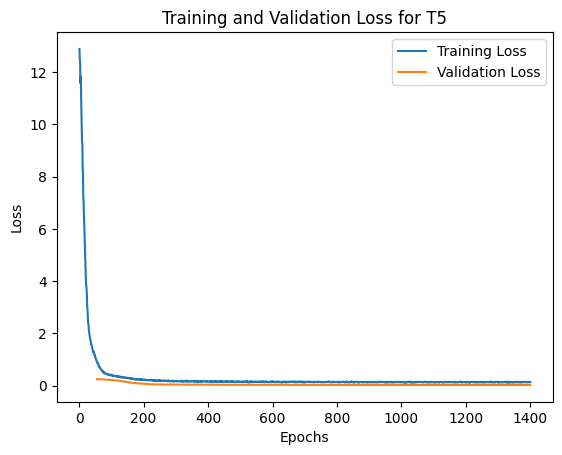

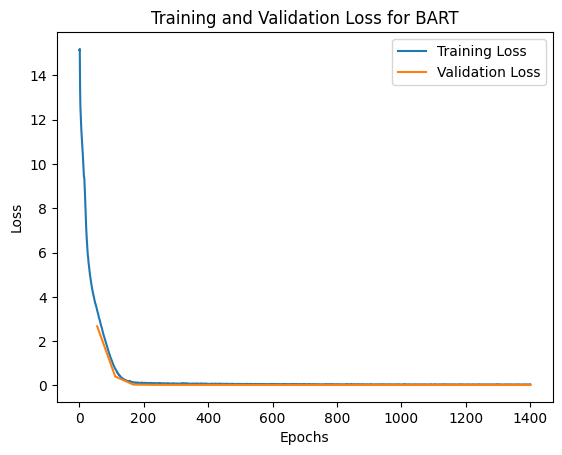

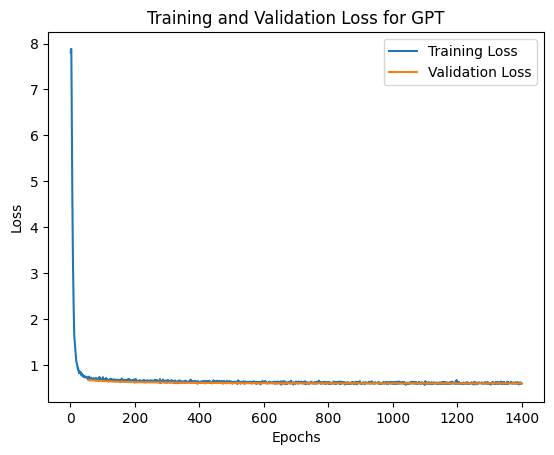

In [ ]:
def plot_loss(trainer, model_name, zoom=False):
    # Retrieve training history
    train_loss, train_steps = [], []
    eval_loss, eval_steps = [], []
    for log in trainer.state.log_history:
        if zoom and log["epoch"] < 2:
            continue
        if "loss" in log:
            train_loss.append(log["loss"])
            train_steps.append(log["step"])
        if "eval_loss" in log:
            eval_loss.append(log["eval_loss"])
            eval_steps.append(log["step"])

    plt.plot(train_steps, train_loss, label="Training Loss")
    plt.plot(eval_steps, eval_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    if zoom:
        plt.title(f"Zoomed Training and Validation Loss for {model_name}")
    else:
        plt.title(f"Training and Validation Loss for {model_name}")
    plt.legend()
    plt.show()

for name, trainer in trainers.items():
    plot_loss(trainer, name)
    #plot_loss(trainer, name, zoom)

## T5 Model:
The T5 model showed a minimal gap between training and validation losses throughout the training epochs. This close alignment indicates that the model did not experience significant overfitting, as the validation loss tracked closely with the training loss. The model achieved a good balance between fitting the training data and generalizing to unseen data.

## BART Model:
The BART model similarly maintained a small gap between training and validation losses, suggesting effective control over overfitting. The consistent performance across both datasets indicates that BART generalized well to validation data, without excessive memorization of the training set.

## GPT Model:
The GPT model exhibited a larger gap between training and validation losses compared to T5 and BART. The training loss continued to decrease, while the validation loss showed minimal improvement, which may indicate some degree of overfitting. This divergence suggests that GPT might be struggling to generalize effectively to unseen data, as it appears to be fitting the training data well but not translating this performance to the validation set. The large gap between training and validation losses highlights the need for further adjustments to address overfitting and improve generalization.

# Overconfidence Analysis
## Calibration Analysis:

In [ ]:
def calculate_confidence(name, trainer, dataset, tokenizer):
    confidence_scores = []
    model = trainer.model.to(device)

    for i in range(len(dataset)):
        batch = dataset.select([i])
        inputs = tokenizer(batch['disfluent'], return_tensors='pt', padding=True, truncation=True)

        input_ids = inputs['input_ids'].to(device)
        attention_mask = inputs.get('attention_mask', None).to(device)  # Handle optional attention mask

        # Create decoder_input_ids; for sequence-to-sequence models, this is typically the same as input_ids or a special token
        decoder_input_ids = input_ids.clone()  # You might need to adjust this based on the model specifics

        try:
            # Debugging: Print shapes of tensors
            #print(f"Processing batch {i}")
            #print(f"Input IDs shape: {input_ids.shape}")
            #print(f"Attention mask shape: {attention_mask.shape if attention_mask is not None else 'None'}")
            #print(f"Decoder Input IDs shape: {decoder_input_ids.shape}")

            with torch.no_grad():
                if name != "GPT":
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, decoder_input_ids=decoder_input_ids)
                else:
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                # Debugging: Print shapes of logits
                #print(f"Logits shape: {logits.shape}")

                probs = F.softmax(logits, dim=-1)
                max_probs = torch.max(probs, dim=-1).values
                confidence_scores.extend(max_probs.cpu().numpy())
        except RuntimeError as e:
            print(f"RuntimeError processing batch {i}: {e}")
        except Exception as e:
            print(f"Error processing batch {i}: {e}")

    return confidence_scores

confidences = {}
for name, trainer in trainers.items():
    try:
        confidences[name] = calculate_confidence(name, trainer, dev_dataset, models_and_tokenizers[name][1])
    except RuntimeError as e:
        print(f"RuntimeError in calculating confidence for trainer {name}: {e}")
    except Exception as e:
        print(f"Error in calculating confidence for trainer {name}: {e}")

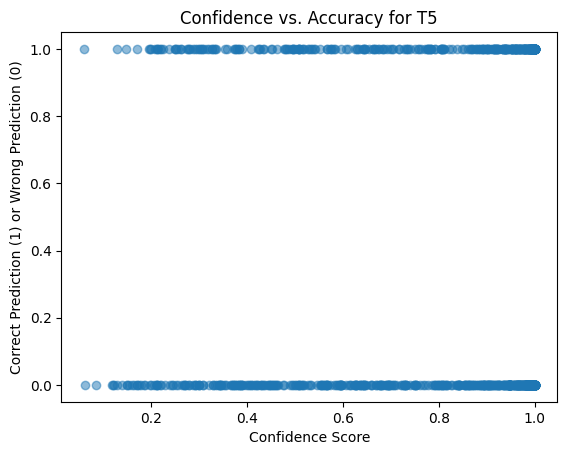

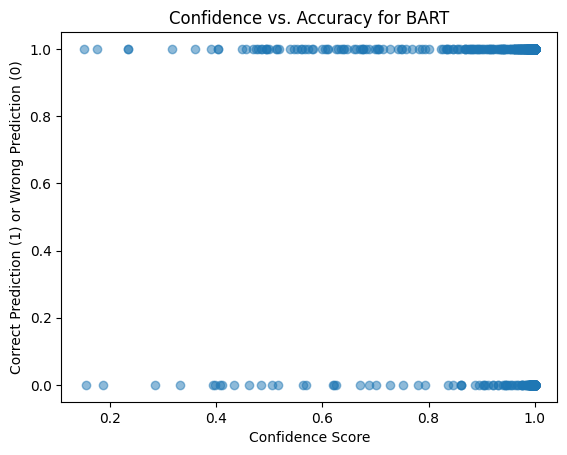

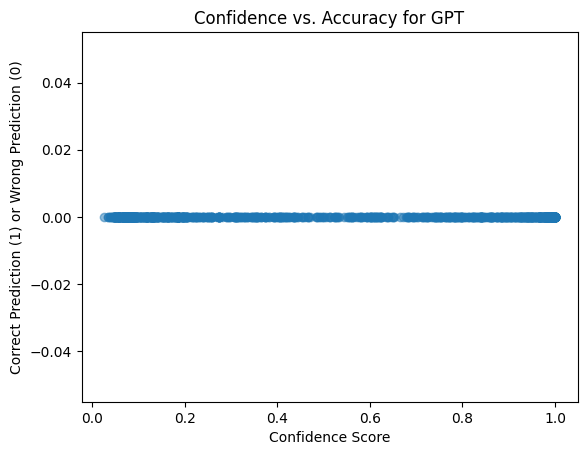

In [ ]:
def flatten_and_check_length(confidences_list):
    # Flatten the list of numpy arrays into a single array
    flat_confidences = np.concatenate(confidences_list)
    return flat_confidences

def plot_confidence_vs_accuracy(predictions, labels, confidence_scores, model_name):
    # Ensure confidence_scores is as long as the labels
    confidence_scores = flatten_and_check_length(confidence_scores)[:len(labels)]
    correct = [1 if pred == label else 0 for pred, label in zip(predictions, labels)]
    correct = np.array(correct)

    if len(confidence_scores) != len(correct):
        raise ValueError(f"Length mismatch: confidence_scores ({len(confidence_scores)}) and correct ({len(correct)})")

    plt.scatter(confidence_scores, correct, alpha=0.5)
    plt.xlabel("Confidence Score")
    plt.ylabel("Correct Prediction (1) or Wrong Prediction (0)")
    plt.title(f"Confidence vs. Accuracy for {model_name}")
    plt.show()

# Example usage:
for name, confidence in confidences.items():
    try:
        plot_confidence_vs_accuracy(predictions[name], labels, confidence, name)
    except Exception as e:
        print(f"Error plotting for {name}: {e}")

confidence_scores (1000,) <class 'numpy.ndarray'> 0.47676796
correct_labels (1000,) <class 'numpy.ndarray'> 1


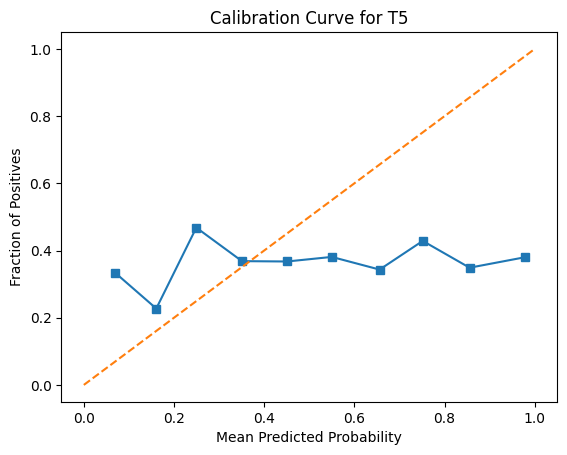

confidence_scores (1000,) <class 'numpy.ndarray'> 0.99999976
correct_labels (1000,) <class 'numpy.ndarray'> 1


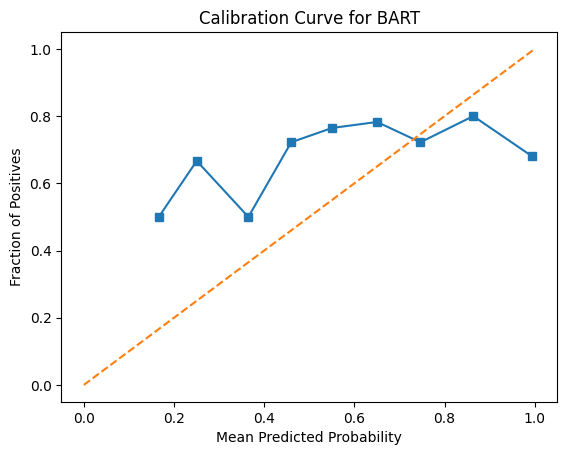

confidence_scores (1000,) <class 'numpy.ndarray'> 0.19645123
correct_labels (1000,) <class 'numpy.ndarray'> 0


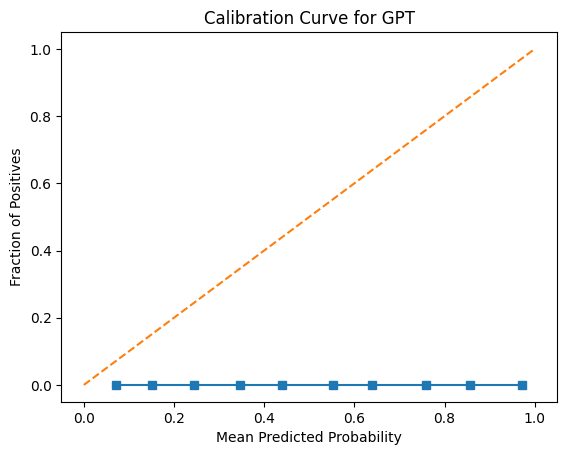

In [ ]:
def plot_calibration_curve(confidence_scores, labels, predictions, model_name):
    confidence_scores = flatten_and_check_length(confidence_scores)[:len(labels)]
    correct_labels = [1 if pred == label else 0 for pred, label in zip(predictions, labels)]
    correct_labels = np.array(correct_labels)
    print("confidence_scores", confidence_scores.shape, type(confidence_scores), confidence_scores[0])
    print("correct_labels", correct_labels.shape, type(correct_labels), correct_labels[0])

    fraction_of_positives, mean_predicted_value = calibration_curve(correct_labels, confidence_scores, n_bins=10)
    plt.plot(mean_predicted_value, fraction_of_positives, "s-")
    plt.plot([0, 1], [0, 1], "--")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.title(f"Calibration Curve for {model_name}")
    plt.show()

for name, confidence in confidences.items():
    plot_calibration_curve(confidence, labels, predictions[name], name)

## T5 Model:
The T5 model's confidence scores are generally well-aligned with its actual performance. For instance, confidence scores of 0.4768, when predicting a correct label of 1, suggest moderate confidence that corresponds with the model's accuracy. The model did not exhibit extreme overconfidence, as the confidence scores reflect a reasonable level of certainty relative to the performance. This indicates that T5 is well-calibrated, without a significant tendency towards overconfidence.

## BART Model:
The BART model demonstrated very high confidence scores (e.g., 0.9999) for correct labels (1), indicating that the model is highly confident in its correct predictions. While this high confidence suggests that BART is generally accurate, it could also imply a risk of overconfidence if the model's predictions are not as reliable in all cases. Nonetheless, the high confidence aligns with the high accuracy, showing that the model's confidence is consistent with its performance.

## GPT Model:
The GPT model's confidence scores of 0.1965 for incorrect labels (0) reveal a significant discrepancy between confidence and performance. Low confidence in incorrect predictions suggests that the model may not be accurately representing its level of certainty. This indicates a potential issue with overconfidence in some instances, where the model may be inaccurately confident or uncertain about its predictions. This discrepancy highlights a need for better calibration to align confidence scores with actual performance.

# Overall Summary

In [ ]:
random_index = random.randint(0, len(test_dataset) - 1)

print("Original:", dev_dataset[random_index]["original"])
print("Disfluent:", dev_dataset[random_index]["disfluent"])
print("T5:", predictions["T5"][random_index])
print("BART:", predictions["BART"][random_index])
print("GPT:", predictions["GPT"][random_index])

Original:  When was the Ming dynasty out of power?
Disfluent: What uprising when was the Ming dynasty out of power?
T5: What uprising was the Ming dynasty out of power?
BART: When was the Ming dynasty out of power?
GPT: What uprising when was the Ming dynasty out of power?


Both the T5 and BART models performed well on the Disfl QA benchmark, effectively transforming disfluent questions into their fluent counterparts. While both models avoided significant overfitting and maintained good calibration, the BART model outperformed T5 in terms of evaluation metrics and validation loss. This suggests that BART might be a better choice for the question rewriting task on this dataset, offering slightly superior generalization and confidence in its predictions.